In [1]:
import warnings
from warnings import simplefilter
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from tqdm.notebook import tqdm
import optuna
import shap

from data_utils import check_missing
from get_metrics import get_metrics_regression

warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)
sns.set()

RAND = 10
N_FOLDS = 3

# Описание задачи

**Цель проекта:** Спарсить данные о фильмах с сайта Кинопоиск, провести их анализ и разработать модель машинного обучения для прогнозирования сборов фильма в США.

**Цель текущего ноутбука:** 
<br>Тюнинг и оптимизация ранее выбранных базовых моделей машинного обучения для достижения лучшего качества прогнозирования. Основной акцент делается на настройке гиперпараметров и использовании различных стратегий валидации.

**Основные этапы работы с тюнингом моделей:**

**1. Подготовка данных:**
   - Переиспользование данных из предыдущего ноутбука и их дальнейшая обработка при необходимости.

**2. Тюнинг гиперпараметров:**
   - Использование различных методов (например, случайный поиск, кросс-валидация) для оптимизации гиперпараметров выбранных моделей.

**3. Оценка улучшенных моделей:**
   - После настройки гиперпараметров, повторное обучение моделей и оценка их производительности на тестовой выборке.

**4. Анализ важности признаков:**
   - Использование различных методов (SHAP, permutation importance) для определения наиболее важных признаков в модели.

**5. Выводы и рекомендации:**
   - Определение, какие из оптимизированных моделей являются наиболее эффективными и что еще можно улучшить в будущем.

# Импорт данных

In [2]:
df = pd.read_csv('data/movies_2019_imdb.csv')
df =df.drop(['movie_id'], axis=1)
df.ratingMpaa.fillna('nan', inplace=True)

# Переводим категоризованные данные
cat_cols = df.select_dtypes('object').columns
df[cat_cols] = df[cat_cols].astype("category")

**Описание полей:**

- **votes_kp, votes_imdb** - количество оценок фильма на Кинопоиске и IMDB
- **rating_kp, rating_imdb** - рейтинги фильма на Кинопоиске и IMDB
- **votes_filmCritics** - количество оценок кинокритиков в мире
- **rating_filmCritics** - рейтинг кинокритиков в мире
- **votes_await** - количество ожидающих фильм на Кинопоиске
- **movieLength** - длина фильма
- **movie_age** - возраст фильма
- **ageRating, ratingMpaa** - возрастные рейтинги фильма
- **type** - тип картины (фильм/мультфильм)
- **fees_usa** - сборы фильма в США
- **fees_usa_log** - логарифмированные сборы фильма в США
- **budget_in_usd** - бюджет фильма
- **videos_trailers_number** - количество трейлеров
- **actor_metric_2019** - метрика актеров фильма
- **writer_metric_2019** - метрика сценаристов фильма
- **director_metric_2019** - метрика режиссеров фильма
- колонки с перфиксом **genres_** - бинаризованные колонки жанров фильма
- колонки с перфиксом **countries_** - бинаризованные колонки стран фильма
- колонки с перфиксом **Spetseffekty_** - бинаризованные колонки студий спецэффектов
- колонки с перфиксом **Proizvodstvo_** - бинаризованные колонки студий производства

In [3]:
df[:5]

,votes_kp,votes_imdb,votes_filmCritics,votes_await,rating_kp,rating_imdb,rating_filmCritics,movieLength,ageRating,ratingMpaa,...,Proizvodstvo_Millennium_Films,Proizvodstvo_NBC_Universal_Television,Proizvodstvo_New_Line_Cinema,Proizvodstvo_Paramount_Pictures,Proizvodstvo_Relativity_Media,Proizvodstvo_Silver_Pictures,Proizvodstvo_Studio_Canal,Proizvodstvo_Universal_Pictures,Proizvodstvo_Village_Roadshow_Pictures,Proizvodstvo_Warner_Bros_Pictures
0,1678838.0,895482.0,130.0,15.0,8.813,8.5,6.8,112.0,18.0,r,...,0,0,0,0,0,0,0,0,0,0
1,1524128.0,372380.0,277.0,13642.0,8.562,7.8,6.5,113.0,18.0,r,...,0,0,0,0,0,0,0,0,0,0
2,1125382.0,1471424.0,289.0,43024.0,7.976,8.2,7.8,180.0,18.0,r,...,0,0,0,0,0,0,0,0,0,0
3,1014540.0,1359191.0,335.0,38689.0,7.972,7.9,7.4,162.0,12.0,pg13,...,1,0,0,0,0,0,0,0,0,0
4,953836.0,742208.0,474.0,9141.0,8.102,7.9,8.3,130.0,18.0,pg13,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.shape

(4816, 93)

In [5]:
# Метрики бэйзлайнов
metrics_baseline = pd.read_csv('data/metrics_baseline.csv')
metrics_baseline['model'] = metrics_baseline['model']+'_baseline'
metrics_baseline

,model,MAE,R2 adjusted,WAPE_%,overfitting_%_MAE,overfitting_%_R2 adjusted,overfitting_%_WAPE_%
0,CatBoost_test_2019_log_baseline,2.077320e+07,0.598395,53.138286,22.603333,23.392106,24.544193
1,LGBM_test_2019_log_votes&ratings_baseline,1.504018e+07,0.752853,38.473095,35.545647,13.366609,37.161955


В колонках с префиксом "overfitting_\%_" записаны значения переобучения моделей по соответствующим метрикам в процентах, вычисленные с помощью следующей функции:

In [6]:
def evaluate_overfitting(metrics_df: pd.DataFrame,
                         metric_names: List[str]) -> pd.DataFrame:
    """
    Оценивает переобучение, сравнивая метрики на обучающем и тестовом наборах.
    Добавляет колонки со значениями переобучения метрик в процентах
    с префиксом overfitting_%_

    Parameters:
    - metrics_df: DataFrame с метриками
    - metric_names: список имен метрик, которые следует проверить

    Returns:
    - DataFrame с метриками и столбцами процентного изменения метрик
    """

    # Добавляем столбец 'base_model_name' без подстрок "train" или "test"
    metrics_df['base_model_name'] = metrics_df['model'].str.replace(
        'train', '_').str.replace('test', '_')

    # Отбираем только строки, связанные с тренировкой и тестированием
    train_metrics = metrics_df[metrics_df['model'].str.contains(
        'train')][['base_model_name'] + metric_names]

    test_metrics = metrics_df[metrics_df['model'].str.contains(
        'test')][['base_model_name'] + metric_names]

    # Соединяем две таблицы по 'base_model_name'
    combined = train_metrics.set_index('base_model_name').join(
        test_metrics.set_index('base_model_name').rename(
            columns={name: name + '_test'
                     for name in metric_names}),
        how='inner')

    # Рассчитываем процентное переобучение для каждой метрики
    # По формуле: (metric_train - metric_test)/metric_test*100
    for metric_name in metric_names:
        combined['overfitting_%_' + metric_name] = abs(
            ((combined[metric_name] - combined[metric_name + '_test']) /
             combined[metric_name + '_test']) * 100)

    # Присоединяем столбцы процентного переобучения к исходной таблице метрик
    for metric_name in metric_names:
        metrics_df = metrics_df.merge(combined[['overfitting_%_' + metric_name]],
                                      left_on='base_model_name',
                                      right_index=True,
                                      how='left')

    return metrics_df.drop(columns=['base_model_name'])

# Разделение на train и test выборки

In [7]:
# Используем логарифмированную целевую переменную
X = df.drop(['fees_usa', 'fees_usa_log'], axis=1)
y = df['fees_usa_log']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=RAND)

# Tuning LighGBM - на данных до 2020, с оценками и рейтингами

## Поиск learning rate с помощью Optuna

In [ ]:
def objective_lgb(trial, X, y, random_state=10):

    lgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [300]),
        "learning_rate": trial.suggest_float("learning_rate",
                                             0.001,
                                             0.3,
                                             log=True)
    }

    # Инициализация метода кросс-валидации KFold, где датасет разбивается на N_FOLDS частей.
    # Данные перед разбиением перемешиваются (shuffle=True)
    # random_state гарантирует одинаковое разбиение при каждом запуске
    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)

    cv_mae_scores = np.empty(N_FOLDS)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Создание callback для Optuna, чтобы рано прекращать исследование,
        # если текущие результаты неперспективны.
        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, "l1")

        # Инициализация модели LightGBM с параметрами, определенными Optuna,
        # и механизмом ранней остановки при построении деревьев
        model = LGBMRegressor(**lgb_params,
                              early_stopping_rounds=100,
                              verbose=0)

        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="mae",
                  callbacks=[pruning_callback])

        preds = model.predict(X_test)

        # Преобразование предсказаний и y_test обратно из логарифмической шкалы
        preds_transformed = np.expm1(preds)
        y_test_transformed = np.expm1(y_test)

        # Вычисление MAE на исходной шкале данных
        mae_original_scale = mean_absolute_error(y_test_transformed,
                                                 preds_transformed)

        cv_mae_scores[idx] = mae_original_scale

    return np.mean(cv_mae_scores)


study = optuna.create_study(direction="minimize", study_name="LGB")


def func(trial):
    return objective_lgb(trial, X_train, y_train, random_state=RAND)


optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(func, n_trials=10, show_progress_bar=True)

In [71]:
learning_rate = study.best_params['learning_rate']
n_estimators = study.best_params['n_estimators']
study.best_params, study.best_value

({'n_estimators': 300, 'learning_rate': 0.043748257582522064},
 16013662.384938246)

## Tuning с помощью Optuna

In [ ]:
def objective_lgb(trial, X, y, random_state=10):

    lgb_params = {
        "n_estimators":
        trial.suggest_categorical("n_estimators", [n_estimators]),
        "learning_rate":
        trial.suggest_categorical("learning_rate", [learning_rate]),
        "num_leaves":
        trial.suggest_int("num_leaves", 20, 1000, step=20),
        "max_depth":
        trial.suggest_int("max_depth", 3, 12),
        "max_bin":
        trial.suggest_int("max_bin", 20, 3300, step=10),

        # Minimum number of data needed in a child (leaf).
        "min_child_samples":
        trial.suggest_int("min_child_samples", 10, 3000, step=10),
        "reg_alpha":
        trial.suggest_int("reg_alpha", 0, 100),
        "reg_lambda":
        trial.suggest_int("reg_lambda", 0, 100),
        "subsample":
        trial.suggest_float("subsample", 0.2, 1.0),
        "subsample_freq":
        trial.suggest_categorical("subsample_freq", [1]),
        "colsample_bytree":
        trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "objective":
        trial.suggest_categorical("objective", ["mae"]),
        "random_state":
        trial.suggest_categorical("random_state", [random_state])
    }

    # Инициализация метода кросс-валидации KFold, где датасет разбивается на N_FOLDS частей.
    # Данные перед разбиением перемешиваются (shuffle=True)
    # random_state гарантирует одинаковое разбиение при каждом запуске
    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)

    cv_mae_scores = np.empty(N_FOLDS)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Создание callback для Optuna, чтобы рано прекращать исследование,
        # если текущие результаты неперспективны.
        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, "l1")

        # Инициализация модели LightGBM с параметрами, определенными Optuna,
        # и механизмом ранней остановки при построении деревьев
        model = LGBMRegressor(**lgb_params,
                              early_stopping_rounds=100,
                              verbose=0)

        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="mae",
                  callbacks=[pruning_callback])

        preds = model.predict(X_test)

        # Преобразование предсказаний и y_test обратно из логарифмической шкалы
        preds_transformed = np.expm1(preds)
        y_test_transformed = np.expm1(y_test)

        # Вычисление MAE на исходной шкале данных
        mae_original_scale = mean_absolute_error(y_test_transformed,
                                                 preds_transformed)

        cv_mae_scores[idx] = mae_original_scale

    return np.mean(cv_mae_scores)


study = optuna.create_study(direction="minimize", study_name="LGB")


def func(trial):
    return objective_lgb(trial, X_train, y_train, random_state=RAND)


optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(func, n_trials=20, show_progress_bar=True)

In [77]:
params_lgb = study.best_params
study.best_params

{'n_estimators': 300,
 'learning_rate': 0.043748257582522064,
 'num_leaves': 20,
 'max_depth': 12,
 'max_bin': 2820,
 'min_child_samples': 20,
 'reg_alpha': 37,
 'reg_lambda': 30,
 'subsample': 0.827098987950252,
 'subsample_freq': 1,
 'colsample_bytree': 0.6654507490508481,
 'objective': 'mae',
 'random_state': 10}

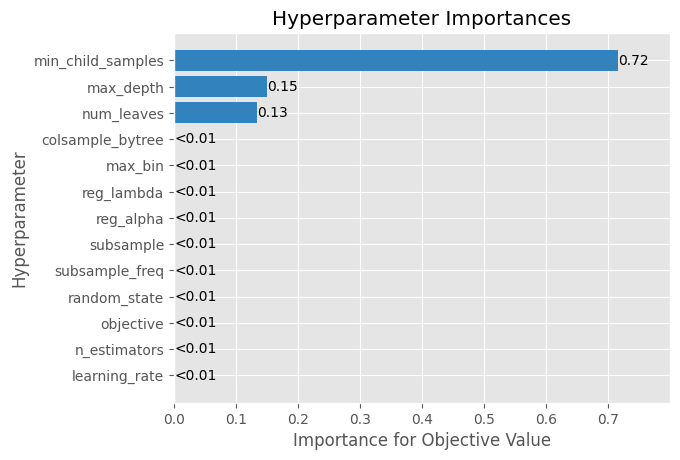

In [78]:
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization import plot_optimization_history

plot_param_importances(study);

1. **min_child_samples** является наиболее влиятельным гиперпараметром для модели, его значение имеет самую большую важность (0.72).
2. **max_depth** и **num_leaves** также имеют относительно высокую значимость, хотя и намного меньше, чем у **min_child_samples**.
3. Остальные гиперпараметры имеют низкую значимость (<0.1), что говорит о том, что они менее критичны для оптимизации данной модели.

## Обучение LighGBM на лучших параметрах

In [9]:
# Добавим разделение на валидационную выборку
X_train_, X_val, y_train_, y_val = train_test_split(
                                                X_train,
                                                y_train,
                                                test_size=0.16,
                                                shuffle=True,
                                                random_state=RAND)

eval_set = [(X_val, y_val)]

lgb_grid = LGBMRegressor(verbose=-1,
                         early_stopping_rounds=100,
                         **params_lgb
                        )

lgb_grid.fit(X_train_,
             y_train_,
             eval_metric="mae",
             eval_set=eval_set
             )

LGBMRegressor(colsample_bytree=0.6654507490508481, early_stopping_rounds=100,
              learning_rate=0.043748257582522064, max_bin=2820, max_depth=12,
              n_estimators=300, num_leaves=20, objective='mae', random_state=10,
              reg_alpha=37, reg_lambda=30, subsample=0.827098987950252,
              subsample_freq=1, verbose=-1)

In [10]:
y_pred = lgb_grid.predict(X_test)
y_pred_train = lgb_grid.predict(X_train_)

# Преобразование обратно из логарифмической шкалы
y_pred = np.expm1(y_pred)
y_pred_train = np.expm1(y_pred_train)

y_test_exp = np.expm1(y_test)
y_train_exp = np.expm1(y_train_)

metrics_test = get_metrics_regression(
    y_test=y_test_exp.values,
    y_pred=y_pred,
    X_test=X_test,
    name='LGBM_test_2019_log_votes&ratings_Optuna')

metrics_train = get_metrics_regression(
    y_test=y_train_exp.values,
    y_pred=y_pred_train,
    X_test=X_train_,
    name='LGBM_train_2019_log_votes&ratings_Optuna')

metrics_lgbm = pd.concat([metrics_train, metrics_test])
metrics_lgbm = metrics_lgbm[['model', 'MAE', 'R2 adjusted', 'WAPE_%']].copy()

In [15]:
# Метрики на train и на test
metrics_lgbm.set_index('model')  

,MAE,R2 adjusted,WAPE_%
model,,,
LGBM_train_2019_log_votes&ratings_Optuna,1.332529e+07,0.760047,33.231602
LGBM_test_2019_log_votes&ratings_Optuna,1.561196e+07,0.712493,39.935729


In [12]:
# Рассчитаем процент переобучения и добавим в таблицу с метрикам baseline
# Запишем процент переобучения в колонки с префиксом "overfitting_%_"
metrics_lgbm = evaluate_overfitting(metrics_lgbm,
                                    ['MAE', 'R2 adjusted', 'WAPE_%'])

mask = metrics_lgbm.model.str.contains('test')
all_metrics = pd.concat([metrics_baseline, metrics_lgbm[mask]])
all_metrics = all_metrics.set_index('model')

In [29]:
all_metrics.loc[['LGBM_test_2019_log_votes&ratings_baseline', 
                'LGBM_test_2019_log_votes&ratings_Optuna']]

,MAE,R2 adjusted,WAPE_%,overfitting_%_MAE,overfitting_%_R2 adjusted,overfitting_%_WAPE_%
model,,,,,,
LGBM_test_2019_log_votes&ratings_baseline,1.504018e+07,0.752853,38.473095,35.545647,13.366609,37.161955
LGBM_test_2019_log_votes&ratings_Optuna,1.561196e+07,0.712493,39.935729,14.646910,6.674377,16.787291


**Анализ метрик для моделей на основе LightGBM**:

1. **Сравнение моделей**:
   - Модель **baseline** в целом показывает лучшие результаты по сравнению с моделью **Optuna** по всем трём основным метрикам.


2. **MAE (Средняя абсолютная ошибка)**:
   - **baseline** имеет MAE примерно в `$15,040,180`, что на примерно `$570,178` меньше, чем у **Optuna**. Это означает, что прогнозы модели **baseline** в среднем отклоняются на $15 млн от реальных значений, что является достаточно большим разбросом. Но при этом, **Optuna** отклоняется еще больше.


3. **R2 adjusted**:
   - **baseline** имеет R2 adjusted равный 0.752853, что на 0.04036 больше, чем у **Optuna**. Это указывает на более высокое качество прогнозов у **baseline**.


4. **WAPE_%**:
   - **baseline** имеет WAPE_% равный 38.47%, что на 1.46% меньше, чем у **Optuna**.


5. **Метрики переобучения**:
   - По всем трём метрикам переобучения (**overfitting_\%_MAE**, **overfitting_\%_R2 adjusted** и **overfitting_\%_WAPE_%**), **baseline** показывает худшие результаты.


**Заключение**: 
- Модель LGBM **baseline** лучше справляется с задачей прогнозирования на тестовых данных, но имеет признаки переобучения. 
- LGBM **Optuna**, хоть и уступает в качестве прогнозов, но менее подверженна переобучению. 

## Важность признаков

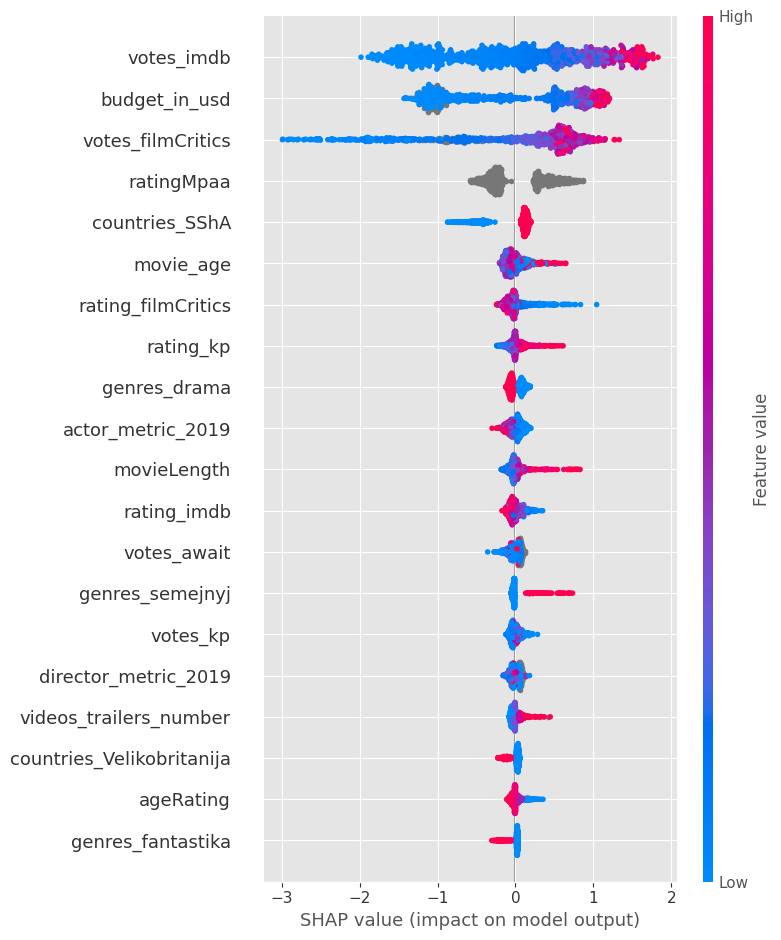

In [79]:
explainer = shap.TreeExplainer(lgb_grid, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

1. Самые важные признаками, влияющие на целевую переменную:

- **votes_imdb (кол-во оценок на IMDb)**, 
- **budget_in_usd (бюджет фильма)**, 
- **votes_film_critics (кол-во оценок кинокритиков в мире)**: 


   - Синий цвет указывает на низкие значения признака, а красный — на высокие. Низкие значения кол-ва оценок `votes_imdb` могут уменьшать прогнозируемое значение сборов фильма, а высокие — увеличивать. Признаки budget_in_usd и votes_film_critics имеют аналогичные свойства.

2. **ratingMpaa**: Четвертый по важности признак - полностью серый, так как он является категориальным признаком.

3. **countries_SShA**: Признак, связанный со страной (США), также имеет влияние на прогноз. Фильмы, произведенные в США, имеют тенденцию к повышению прогнозируемого значения сборов по сравнению с фильмами из других стран.

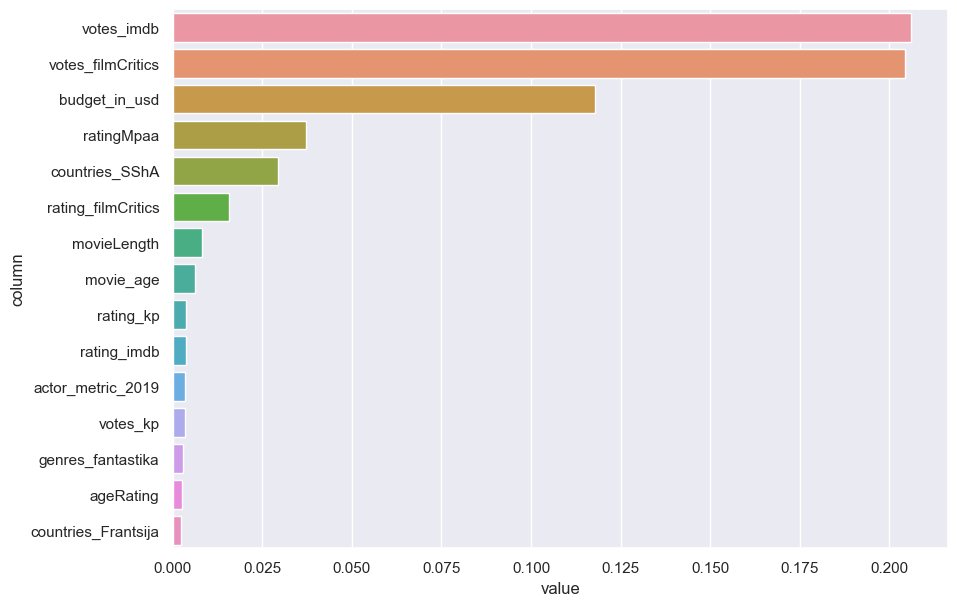

In [17]:
# Используя функцию permutation_importance из библиотеки sklearn, 
# оцениваем важность каждого признака для модели. 
# Этот метод измеряет изменение в точности модели после того, 
# как значения одного признака были случайно перемешаны.
r = permutation_importance(lgb_grid,
                           X_test,
                           y_test,
                           n_repeats=4,
                           random_state=RAND)

# Создаем DataFrame для хранения результатов важности признаков.
feature_imp = pd.DataFrame()
feature_imp['column'] = X_test.columns
feature_imp['value'] = r['importances_mean']

# Сортируем признаки по их важности.
feature_imp.sort_values(by='value', inplace=True, ascending=False)

# отображаем топ-15 наиболее важных признаков.
plt.figure(figsize=(10, 7))
sns.barplot(data=feature_imp[:15], x='value', y='column');

На основе анализа важности признаков с помощью метода перестановочной важности permutation_importance из библиотеки **sklearn** и библиотеки **SHAP**, можно сделать следующие выводы:

1. **Признаки `votes_imdb`, `votes_filmCritics`, и `budget_in_usd`** являются тремя наиболее важными признаками для модели. Эти признаки имеют наибольший вклад в прогнозирование, и это подтверждается обоими методами анализа.
 
2. **Признаки `ratingMpaa` и `countries_SShA`** также оказались в топ-5 признаков по важности в обоих анализах.

3. Этот анализ подтверждает, что выбранные методы интерпретации модели согласованы в своих выводах. Такое совпадение увеличивает уверенность в корректности интерпретации важности признаков.

## Кросс-валидация

In [14]:
# Используем 5-кратную кросс-валидацию для обучения и валидации модели 
# на разных подмножествах тренировочных данных

folds = KFold(n_splits=5, random_state=RAND, shuffle=True)
score_oof = []
predictions_test = []

# Для каждого разбиения данных обучаем модель и сохраняем прогнозы
for fold, (train_index, test_index) in enumerate(folds.split(X_train, y_train)):

    X_train_, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

    model = LGBMRegressor(verbose=-1,
                         early_stopping_rounds=100,
                         **params_lgb
                        )

    model.fit(X_train_,
              y_train_,
              eval_set=[(X_val, y_val)],
              eval_metric='mae', 
             )

    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    metric = mean_absolute_error(np.expm1(y_val), np.expm1(y_pred_val))
    
    # Печатаем значение метрики MAE для каждого разбиения
    print("Fold:", fold + 1, "MAE %.3f" % metric)
    print("---")

    # oof list
    score_oof.append(metric)
    # holdout list
    predictions_test.append(np.expm1(y_pred_test))

Fold: 1 MAE 16219170.150
---
Fold: 2 MAE 17619318.212
---
Fold: 3 MAE 17198559.876
---
Fold: 4 MAE 16253404.220
---
Fold: 5 MAE 15949108.176
---


In [30]:
# Усредняем прогнозы на тестовом наборе данных для окончательного прогноза
predictions_test_mean = np.mean(
    np.column_stack(np.array(predictions_test)),
    axis=1
)

metrics_cv = get_metrics_regression(
    y_test=y_test_exp.values,
    y_pred=predictions_test_mean,
    X_test=X_test,
    name='LGBM_test_2019_log_votes&ratings_CV')

all_metrics = pd.concat([
    all_metrics,
    metrics_cv.set_index('model')[['MAE', 'R2 adjusted', 'WAPE_%']],
])

all_metrics[all_metrics.index.str.contains('LGBM')]

,MAE,R2 adjusted,WAPE_%,overfitting_%_MAE,overfitting_%_R2 adjusted,overfitting_%_WAPE_%
model,,,,,,
LGBM_test_2019_log_votes&ratings_baseline,1.504018e+07,0.752853,38.473095,35.545647,13.366609,37.161955
LGBM_test_2019_log_votes&ratings_Optuna,1.561196e+07,0.712493,39.935729,14.646910,6.674377,16.787291
LGBM_test_2019_log_votes&ratings_CV,1.562643e+07,0.720684,39.972741,NaN,NaN,NaN


В процессе кросс-валидации модель показала среднее значение MAE около `$16-17` млн. Эти значения варьируются от разбиения к разбиению, что подтверждает стабильность модели.

Модель LGBM с настройками, полученными через Optuna, имеет MAE в `$15.61` млн, а модель LGBM с кросс-валидацией - чуть больше, `$15.62` млн. Эти значения очень близки, что говорит о консистентности модели.

# Tuning CatBoost - на данных до 2020 без оценок и рейтингов

In [16]:
# Удаление признаков, связанных с оценками и рейтингами, 
# так как они не известны до релиза фильма.
votes_ratings = [
    'votes_kp',
    'votes_imdb',
    'votes_filmCritics',
    'rating_kp',
    'rating_imdb',
    'rating_filmCritics'
]

df = df.drop(votes_ratings, axis=1)

In [17]:
# Используем логарифмированную целевую переменную для обучения модели
X = df.drop(['fees_usa', 'fees_usa_log'], axis=1)
y = df['fees_usa_log']

# Разбиваем данные на тренировочные и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=RAND)

# Еще одна разбивка для валидационного набора данных
X_train_, X_val, y_train_, y_val = train_test_split(
                                                X_train,
                                                y_train,
                                                test_size=0.16,
                                                shuffle=True,
                                                random_state=RAND)

eval_set = [(X_val, y_val)]

# Создаем список категориальных признаков для модели CatBoost
cat_features = X_val.select_dtypes('category').columns.tolist()

## Поиск learning rate

In [ ]:
# Настройка гиперпараметров модели CatBoost.
# Основной фокус на параметре learning rate.
grid = {
    "n_estimators": [300],
    "learning_rate": np.linspace(0.001, 0.3, 40),
    "random_state": [RAND]

}

# Инициализация модели CatBoost
model = CatBoostRegressor(loss_function="MAE",
                          eval_metric="MAE",
                          cat_features=cat_features,
                          silent=True)

# Производим поиск по сетке с визуализацией результатов
grid_search_result = model.grid_search(grid,
                                       X=X_train,
                                       y=y_train,
                                       plot=True) 

In [141]:
# Извлекаем оптимальные параметры (learning rate и количество итераций) после поиска
learning_rate = grid_search_result['params']['learning_rate']
n_estimators = grid_search_result['params']['iterations']

# Выводим параметры для проверки
grid_search_result['params']

{'random_seed': 10, 'iterations': 300, 'learning_rate': 0.08533333333333333}

## Tuning с помощью randomized_search Catboost

In [ ]:
# Определяем диапазоны параметров для случайного поиска
grid = {
    "n_estimators": [n_estimators],
    "learning_rate": [learning_rate],
    "boosting_type": ['Ordered', 'Plain'],
    "max_depth": list(range(3, 12)),
    "l2_leaf_reg": np.logspace(-6, 3, 10),

    "bootstrap_type": ["Bayesian", "Bernoulli", "MVS", "No"],
    "border_count": np.linspace(10, 510, 20).astype(int),
    'grow_policy': ["SymmetricTree", "Depthwise", "Lossguide"],
    "random_state": [RAND]

}

# Инициализация модели CatBoost
model = CatBoostRegressor(loss_function="MAE",
                          eval_metric="MAE",
                          cat_features=cat_features,
                          silent=True)

# Выполняем случайный поиск по гиперпараметрам с визуализацией результатов
grid_search = model.randomized_search(grid,
                                       X=X_train,
                                       y=y_train,
                                       plot=True)

In [144]:
# Выводим оптимальные параметры после случайного поиска
params_cat = grid_search['params']
grid_search['params']

{'border_count': 10,
 'random_seed': 10,
 'depth': 4,
 'iterations': 300,
 'learning_rate': 0.08533333333333333,
 'l2_leaf_reg': 0.001,
 'grow_policy': 'SymmetricTree',
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS'}

## Обучение Catboost на лучших параметрах

In [19]:
cat_grid = CatBoostRegressor(**params_cat, 
                             loss_function='MAE',
                             eval_metric='MAE')
cat_grid.fit(X_train_,
             y_train_,
             cat_features=cat_features,
             eval_set=eval_set,
             verbose=False,
             early_stopping_rounds=100)

In [20]:
y_pred = cat_grid.predict(X_test)
y_pred_train = cat_grid.predict(X_train_)

# Преобразование обратно из логарифмической шкалы
y_pred = np.expm1(y_pred)
y_pred_train = np.expm1(y_pred_train)

y_test_exp = np.expm1(y_test)
y_train_exp = np.expm1(y_train_)

In [21]:
metrics_test = get_metrics_regression(
    y_test=y_test_exp.values,
    y_pred=y_pred,
    X_test=X_test,
    name='Catboost_test_2019_log_RandSearch')

metrics_train = get_metrics_regression(
    y_test=y_train_exp.values,
    y_pred=y_pred_train,
    X_test=X_train_,
    name='Catboost_train_2019_log_RandSearch')

metrics_cat = pd.concat([metrics_train, metrics_test])
metrics_cat = metrics_cat[['model', 'MAE', 'R2 adjusted', 'WAPE_%']].copy()

# Метрики на train и на test
metrics_cat.set_index('model')  

,MAE,R2 adjusted,WAPE_%
model,,,
Catboost_train_2019_log_RandSearch,1.752313e+07,0.672495,43.700463
Catboost_test_2019_log_RandSearch,2.135433e+07,0.574088,54.624809


In [22]:
# Рассчитаем процент переобучения для всех метрик
# Запишем их в колонки с префиксом "overfitting_%_"
metrics_cat = evaluate_overfitting(metrics_cat,
                                    ['MAE', 'R2 adjusted', 'WAPE_%'])

# Оставим в таблице метрики на test
mask = metrics_cat.model.str.contains('test')

metrics_cat = metrics_cat[mask].set_index('model')

all_metrics = pd.concat([all_metrics, metrics_cat])

In [23]:
all_metrics.loc[['CatBoost_test_2019_log_baseline', 'Catboost_test_2019_log_RandSearch']]

,MAE,R2 adjusted,WAPE_%,overfitting_%_MAE,overfitting_%_R2 adjusted,overfitting_%_WAPE_%
model,,,,,,
CatBoost_test_2019_log_baseline,2.077320e+07,0.598395,53.138286,22.603333,23.392106,24.544193
Catboost_test_2019_log_RandSearch,2.135433e+07,0.574088,54.624809,17.941099,17.141388,19.998872


Настройка модели с помощью randomized_search не дала значительного улучшения основных метрик качества.
<br>Однако она положительно сказалась на устойчивости модели, уменьшив признаки переобучения.

## Важность признаков

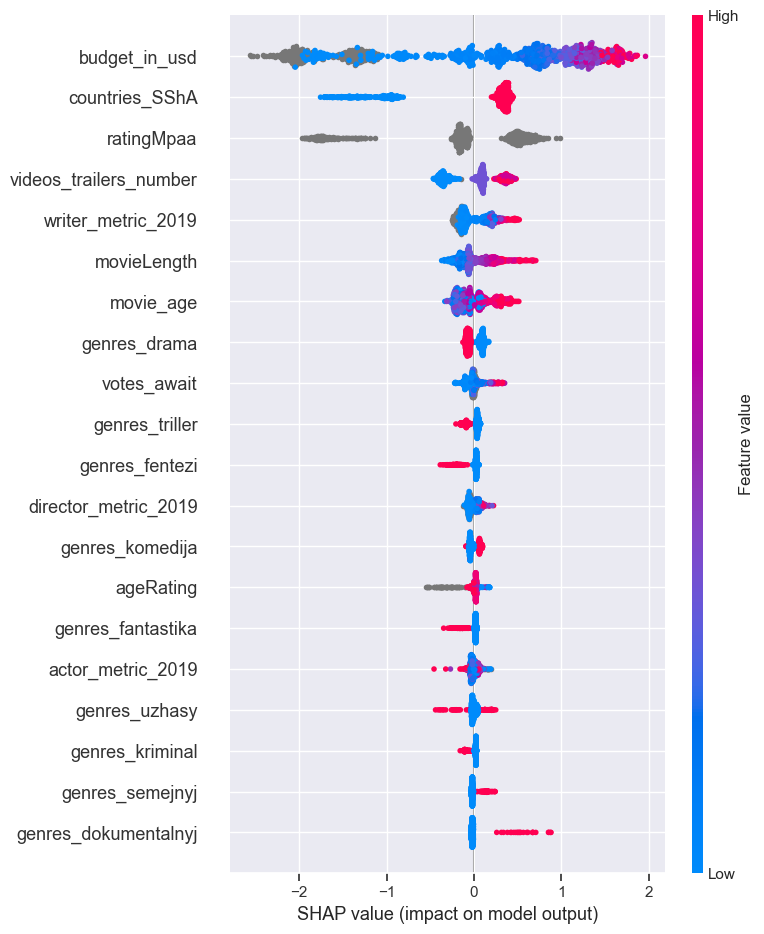

In [34]:
explainer = shap.TreeExplainer(cat_grid, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Рассмотрим 5 первых признаков:

1. **budget_in_usd**: Большие бюджеты обычно связаны с высокими прогнозами сборов. Средний бюджет обычно не влияет на прогноз.

2. **countries_SShA**: Фильмы, произведенные в США, обычно имеют более высокие прогнозы сборов.

3. **ratingMpaa**: Категориальный признак, где некоторые категории рейтинга могут влиять на прогнозы.

4. **videos_trailers_number**: Множество трейлеров может указывать на активную рекламную кампанию и, следовательно, на более высокие прогнозы.

5. **writer_metric**: Известные сценаристы могут улучшить коммерческий успех фильма.

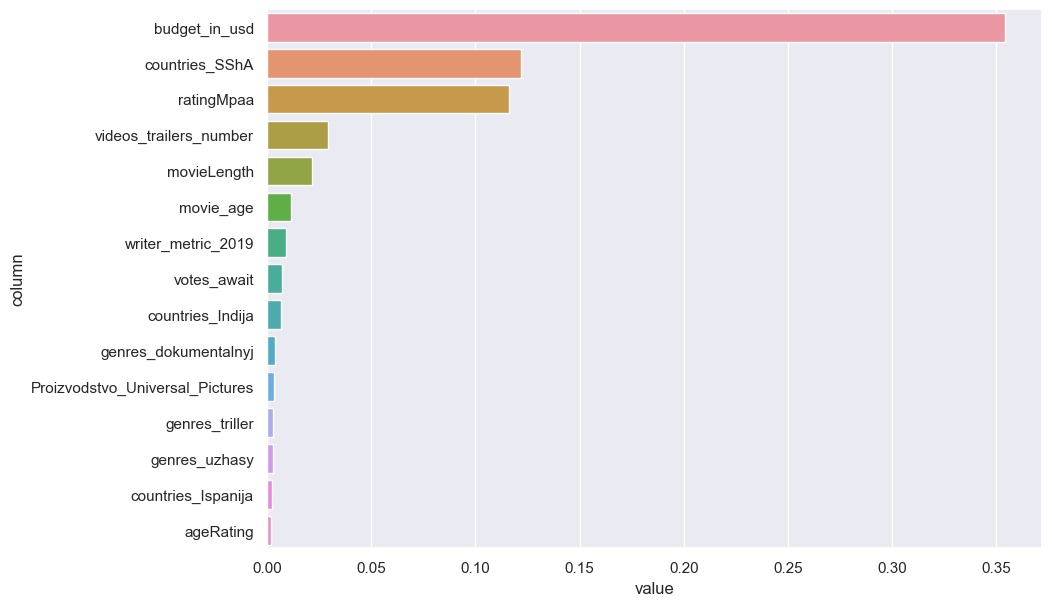

In [50]:
r = permutation_importance(cat_grid,
                           X_test,
                           y_test,
                           n_repeats=4,
                           random_state=RAND)

feature_imp = pd.DataFrame()
feature_imp['column'] = X_test.columns
feature_imp['value'] = r['importances_mean']

feature_imp.sort_values(by='value', inplace=True, ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(data=feature_imp[:15], x='value', y='column');

1. **budget_in_usd**: Как и в предыдущем анализе SHAP, бюджет остается наиболее влиятельным признаком, что подтверждает его ключевую роль в прогнозировании сборов фильма.

2. **countries_SShA**: Этот признак также подтверждает свою важность. Фильмы, произведенные в США, имеют большие прогнозы сборов.

3. **ratingMpaa**: Согласно этому анализу, рейтинг MPAA также имеет значительное влияние на прогнозы, что соответствует результатам SHAP.

4. **videos_trailers_number**: Количество трейлеров, как и ожидалось, также влияет на прогнозы сборов.

5. **movieLength**: Длина фильма вошла в топ-5 важных признаков, хотя в анализе SHAP она не была высоко оценена.

## Кроссвалидация

In [24]:
folds = KFold(n_splits=5, random_state=RAND, shuffle=True)
score_oof = []
predictions_test = []

for fold, (train_index, test_index) in enumerate(folds.split(X_train,
                                                             y_train)):

    X_train_, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

    model = CatBoostRegressor(**params_cat,
                              loss_function='MAE',
                              eval_metric='MAE')

    model.fit(X_train_,
              y_train_,
              cat_features=cat_features,
              eval_set=[(X_val, y_val)],
              verbose=False,
              early_stopping_rounds=100)

    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    metric = mean_absolute_error(np.expm1(y_val), np.expm1(y_pred_val))

    print("Fold:", fold + 1, "MAE %.3f" % metric)
    print("---")

    # oof list
    score_oof.append(metric)
    # holdout list
    predictions_test.append(np.expm1(y_pred_test))

Fold: 1 MAE 22023689.031
---
Fold: 2 MAE 23523203.420
---
Fold: 3 MAE 22641573.204
---
Fold: 4 MAE 20461967.033
---
Fold: 5 MAE 20956206.888
---


In [25]:
# Среднее значение MAE в процессе кросс-валидации
print(np.mean(np.array(score_oof)))

21921327.91534062


In [26]:
# Преобразуем tets и train обратно из логарифмической шкалы
y_test_exp = np.expm1(y_test)

# Усредняем прогнозы на тестовом наборе данных для окончательного прогноза
predictions_test_mean = np.mean(
    np.column_stack(np.array(predictions_test)),
    axis=1
)

metrics_cv = get_metrics_regression(
    y_test=y_test_exp.values,
    y_pred=predictions_test_mean,
    X_test=X_test,
    name='Catboost_test_2019_log_CV')

all_metrics = pd.concat([
    all_metrics,
    metrics_cv.set_index('model')[['MAE', 'R2 adjusted', 'WAPE_%']],
])

In [27]:
all_metrics.loc[[
                 'CatBoost_test_2019_log_baseline', 
                 'Catboost_test_2019_log_RandSearch',
                 'Catboost_test_2019_log_CV']]

,MAE,R2 adjusted,WAPE_%,overfitting_%_MAE,overfitting_%_R2 adjusted,overfitting_%_WAPE_%
model,,,,,,
CatBoost_test_2019_log_baseline,2.077320e+07,0.598395,53.138286,22.603333,23.392106,24.544193
Catboost_test_2019_log_RandSearch,2.135433e+07,0.574088,54.624809,17.941099,17.141388,19.998872
Catboost_test_2019_log_CV,2.085394e+07,0.567574,53.344809,NaN,NaN,NaN


Кросс-валидация позволила получить модель с характеристиками, близкими к базовой.

Это подтверждает надежность и устойчивость базовой модели, поскольку результаты не изменяются сильно даже при изменении обучающего набора данных.

# Итоговые метрики

In [28]:
all_metrics.loc[['LGBM_test_2019_log_votes&ratings_baseline',
                 'LGBM_test_2019_log_votes&ratings_Optuna',
                 'LGBM_test_2019_log_votes&ratings_CV',
                 'CatBoost_test_2019_log_baseline', 
                 'Catboost_test_2019_log_RandSearch',
                 'Catboost_test_2019_log_CV']]

,MAE,R2 adjusted,WAPE_%,overfitting_%_MAE,overfitting_%_R2 adjusted,overfitting_%_WAPE_%
model,,,,,,
LGBM_test_2019_log_votes&ratings_baseline,1.504018e+07,0.752853,38.473095,35.545647,13.366609,37.161955
LGBM_test_2019_log_votes&ratings_Optuna,1.561196e+07,0.712493,39.935729,14.646910,6.674377,16.787291
LGBM_test_2019_log_votes&ratings_CV,1.562643e+07,0.720684,39.972741,NaN,NaN,NaN
CatBoost_test_2019_log_baseline,2.077320e+07,0.598395,53.138286,22.603333,23.392106,24.544193
Catboost_test_2019_log_RandSearch,2.135433e+07,0.574088,54.624809,17.941099,17.141388,19.998872
Catboost_test_2019_log_CV,2.085394e+07,0.567574,53.344809,NaN,NaN,NaN


**Общие выводы**:

- **LGBM vs CatBoost**: 

LGBM на данных, включая голоса и рейтинги, значительно превосходит CatBoost на данных без этих признаков в плане всех рассмотренных метрик.

- **Важность голосов и рейтингов**:

Голоса и рейтинги оказались критически важными для качества прогнозирования. Модель CatBoost без этих признаков показала худшие результаты.

- **Проблемы CatBoost**: 

CatBoost после случайного поиска и кросс-валидации не показал значительного улучшения, что может указывать на сложности с настройкой этой модели для данного набора данных или на необходимость большего количества признаков для обучения.

- **Стабильность LGBM**: 

LGBM оказался более стабильным, демонстрируя небольшие изменения в метриках даже после оптимизации и кросс-валидации.